# Loan Repayment 
## Notebook 1: Data Transformation
<br>
<font size='3'>
Problem statement:<br>
Banks, fintech companies, and other institutions that provide loans rigourously need to analyze the credit score for all clients. There are mechanisms such as underwriting reports which assess the fraud risk for a given potential borrower. However, these risk scoring mechanisms only provide information whether to approve or not approve a certain loan. There are greater risk issues with funded loans when the borrower defaults (do not pay off). 
<br><br>
Hence, this loan repayment task is consequential towards objectively assessing the risk of whether a funded borrower can actually pay off their loans. In essence, this task ultimately results in creating <b>predictive models that can accurately predict whether a funded borrower will pay off (True) or default (False).</b> 
<br><br>
This notebook is the first part of loan repayment task which includes data transformations. Data transformation include cleaning unimportant records and columns, aggregating columns to create new parameter(s), and join data together with other datasets to come up with a set of parameters that will be useful for storytelling later in the exploratory data analysis (eda) notebook. The same data finalised from this notebook will be used for predictive modelling as well.
<br><br>
<b>Note: Please go through this notebook before reviewing eda.ipynb</b>
</font>

## Basic Assumptions
<font size='3'>
The listed assumptions are created based on the data given and logical reasoning behind the loan repayment (according to my understanding of the business):
</font>

 - <font size='3'> The payment records are immutable i.e. no further changes or removal made to existing records. (A)</font><br><br>
 - <font size='3'> Loan status is dynamic, and updates are considered inconsistent. Hence, loan status is not a good indicator of loan repayment (detailed explanation at 'Paid Off Conundrum' section). (B)</font><br><br>
 - <font size='3'> <b>A paid off loan means that total payment for a certain loan matches the originally scheduled amount, or more in cases of penalties. (C)</b> </font><br><br>
 - <font size='3'> The loan application follows these stages where applicable, but in the order of: Applied -> Originated -> Approved -> Funded. (D)</font><br><br>
 - <font size='3'> Each underwriting report is accurate and follows the given guidelines consistently. (E) </font><br><br>

<font size='3'>The decisions made for the transformations in this notebook are based on these assumptions.</font>


 


In [1]:
import os
# Change directory to this file's directory
this_path = globals()['_dh'][-1]
os.chdir(this_path)
print("This file's directory:", os.getcwd())
# Change current path to parent of this file's directory
# to access all modules from parent
os.chdir('..')
source_path = os.getcwd()
print("Parent directory:", source_path)

This file's directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive/notebooks
Parent directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive


In [2]:
from main.data_loader import DataLoader
%matplotlib inline

In [3]:
# Load feather data
os.chdir(source_path)
feather_path = os.path.join(str(os.getcwd()),'data-feathers') 
for _, _, files in os.walk(feather_path):
    for file in files: print(file)

clarity_underwriting_variables
payment
loan
transformed


## Data Transformation on Loan 

<font size="3"> 
 The chosen columns are deemed not useful for loan repayment analysis.  Date columns other than application date are not relevant. However, there is no column indicating when funded loans are actually funded (i.e. date when the loan amount is transfered to borrower). Following the assumption that application date is used as a chronological factor that may affect the loan approval process, the year from application date will be recorded as the year the loan is applied to generalize the chronology. This year field will be useful for EDA later. As for identification columns, only primary/foreign keys are useful for joins later, hence anon_ssn is removed. 
<br><br>
Since this is a loan repayment problem, <b>we only care about funded loans</b>. Therefore, we will only consider funded loans. Columns such as 'originated' and 'approved' precede the stage process of the column 'isFunded' and are removed. 
<br><br>
Joins with other two datasets will be done after their respective transformations.
</font>

In [4]:
# Load loan data
loan_feather_path = os.path.join(feather_path, 'loan')
loan_manager = DataLoader()
loan_manager.load_feather(loan_feather_path)
# loan_manager.display(10, False)  # display last n rows

In [5]:
# Drop unused columns
dropped = ['anon_ssn', 'originated', 'originatedDate', 'approved']
loan_manager.drop_column(dropped)

In [6]:
# Create a new field applicationYear
applicationYear = loan_manager.col_parse_year('applicationDate')
loan_manager.add_col(newcol=applicationYear, colname='applicationYear')


In [7]:
# Now we can drop applicationDate
loan_manager.drop_column(['applicationDate'])

In [8]:
loan_manager.display(5, True)

,loanId,payFrequency,apr,nPaidOff,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,applicationYear
0,LL-I-07399092,B,360.0,0.0,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,None,5669ef78e4b0c9d3936440e6,1,2016
1,LL-I-06644937,B,199.0,0.0,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,2016
2,LL-I-10707532,B,590.0,0.0,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,None,579eab11e4b0d0502870ef2f,1,2016
3,LL-I-02272596,B,360.0,0.0,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,None,555b1e95e4b0f6f11b267c18,1,2015
4,LL-I-09542882,B,590.0,0.0,0,Rejected,350.0,814.37,NV,bvMandatory,3,None,5754a91be4b0c6a2bf424772,1,2016


In [9]:
print("Unique values for isFunded:")
for val in loan_manager.data.isFunded.unique(): print(val)

Unique values for isFunded:
0
1


In [10]:
loan_manager.single_eqfilter('isFunded', 1)  # get all funded loans
loan_manager.drop_column(['isFunded'])  # now we can drop isFunded
print("Shape of all funded loan data:", loan_manager.data.shape)

Shape of all funded loan data: (38982, 14)


## Data transformation for Payment

<font size='3'>There are only three important columns in payment, mainly for aggregation:</font>

- <font size='3'>loanId: </font>         
    - As a foreign key to join with loan data and basis for aggregation
    <br><br>
 - <font size='3'>paymentAmount:  </font> 
   - Aggregated sum for each loanID
   <br><br>
 - <font size='3'>paymentStatus:</font>    
   - Aggregate for only 'Checked' status


In [11]:
# Load payment data
payment_feather_path = os.path.join(feather_path, 'payment')
payment_manager = DataLoader()
payment_manager.load_feather(payment_feather_path)
# payment_manager.display(10, False) # display last n rows

<font size='4'>The intuition behind these transformations:</font>

 - <font size='3'> Enforces a focused scope on payments for loan repayment.</font><br><br>
 - <font size='3'><b>Only consider loan payments that are actually received by the company.</b></font><br><br>
 - <font size='3'>Aggregation of total successful payments yields a grouped sum for each loan.</font><br><br>
 - <font size='3'>Join with the loan dataset later will yield more meaningful results.</font>


In [12]:
# Filter 'Checked' payment status only
payment_manager.single_eqfilter('paymentStatus', 'Checked')
# Filter to only choose loanId and paymentAmount columns
chosen = ['loanId', 'paymentAmount']
payment_manager.chosen_cols(chosen)
print("Shape of all checked payments: ",payment_manager.data.shape)

Shape of all checked payments:  (209621, 2)


In [13]:
# Sum paymentAmount by loanId
group = ['loanId']
target = ['paymentAmount']
agg_payment = payment_manager.groupby_sum(group, target)    # returns a dataframe of summed loans
print("Shape of all loans with at least one successful payment:", agg_payment.shape)
agg_payment.head(5)

Shape of all loans with at least one successful payment: (32168, 2)


,loanId,paymentAmount
0,LL-I-00000021,1865.61
1,LL-I-00000231,258.64
2,LL-I-00000238,1162.60
3,LL-I-00000308,61.59
4,LL-I-00000419,226.31


In [14]:
"""
Now we need to join the loan data and aggregated payments to provide total payments of a loan along with other loan columns.
The intuition is to left join loan data with aggregated payments, as some funded loans might not have any payment at all.
Hence, resulting join will leave some records with blanks on paymentAmount.
"""
# Left join current df of loan_manager with aggregated payment
joined_lp = loan_manager.left_join(agg_payment, left_key='loanId', right_key='loanId')  # do note that joined_lp is a DataFrame and not DataLoader object
joined_lp.paymentAmount = joined_lp.paymentAmount.fillna(0) # Replace NaN in paymentAmount with 0 (since no payment is never paid for this funded loan)
print ("Shape of joined table:", joined_lp.shape)
joined_lp.head(5)

Shape of joined table: (38982, 15)


,loanId,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,applicationYear,paymentAmount
0,LL-I-06644937,B,199.0,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,2016,6287.08
1,LL-I-12263369,B,475.0,2.0,New Loan,350.0,893.88,MO,organic,0,Checked,None,0,2016,481.39
2,LL-I-17826953,W,645.0,0.0,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,1,2017,0.00
3,LL-I-16519347,S,490.0,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,2017,1333.75
4,LL-I-11506719,B,590.0,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,2016,2432.08


In [15]:
# Unique loan statuses for funded loans
print("Loan statuses for funded loans:")
for status in joined_lp.loanStatus.unique(): print(status)

Loan statuses for funded loans:
Paid Off Loan
New Loan
Internal Collection
External Collection
Returned Item
Pending Paid Off
Charged Off Paid Off
Settled Bankruptcy
Settlement Paid Off
Charged Off
Settlement Pending Paid Off


## The 'Paid Off' Conundrum:
<font size='3'>
This is arguably the most important part of this notebook, where a new field 'payOff' is created. this field is created as an indicator whether a loan has been paid off. From initial analysis, it is difficult to pinpoint a field that shows whether a loan has been paid off or not. At first glance, 'loanStatus' could indicate a pay off. Although its true that there is a paid off status is 'loanStatus', there are instances of not updated data in loan data. We can observe that some statuses such as 'New Loan' and 'Pending Paid Off' shows that the database is not updated, following the assumption that these loans are not completed yet when the database is pulled. Therefore, we should drop records with loan status of 'New Loan' and 'Pending Paid Off' as we <b>update the scope of 'we only care about funded loans' into 'we only care about funded loans that are completed' to preserve the truth in loan repayment.</b>
<br><br>
There are also inconsistencies in several instances of 'Paid Off Loan' where only a small portion of aggregated payment amount is recorded compared to the originally scheduled amount. <b>Therefore, we can conclude that 'loanStatus' is not a good indicator whether a given loan is actually paid off.</b> However, the loan status column will be preserved for EDA, but shall be removed later before modelling.
<br><br>
Since we do not have a definitive field as an indicator of whether a loan is paid off, <b>lets create a new boolean field 'paidOff' by first subtracting the aggregated payment amount with the originally scheduled amount; if the value is greater than or equals to 0, then 'paidOff' will be marked True, and False otherwise.</b>
<br><br>
My intuition and logical reasoning from the term 'paid off' is the following: <b>"A loan is paid off only when the borrower completes the repayment as initially scheduled amount together with any penalty fees that may apply." Therefore, this new 'paidOff' field will be used as a target variable for predictive modelling later.</b> From a business standpoint, I believe it is only reasonable that a financial institution want to predict whether a borrower will pay off their loans equal to the initally agreed amount, or else there will be significant loss incured towards the lender.
</font>

In [16]:
# Create new column paidOff
from numpy import where
joined_lp['paidOff'] = where(
        (joined_lp.paymentAmount - joined_lp.originallyScheduledPaymentAmount) >= 0,
        True, False)

In [17]:
# Drop loan records that are not completed
ls_val = ['New Loan', 'Pending Paid Off']
joined_lp = joined_lp[joined_lp.loanStatus.isin(ls_val) == False]
print ("Shape of joined data after drop:", joined_lp.shape)

Shape of joined data after drop: (30701, 16)


In [18]:
# Check loan statuses again
print("Loan statuses for funded loans:")
for status in joined_lp.loanStatus.unique(): print(status)

Loan statuses for funded loans:
Paid Off Loan
Internal Collection
External Collection
Returned Item
Charged Off Paid Off
Settled Bankruptcy
Settlement Paid Off
Charged Off
Settlement Pending Paid Off


In [19]:
# load joined_lp into Data loader for further joins
joined_manager = DataLoader(joined_lp)   

## Underwriting Data Transformation
<font size='3'>
The underwriting dataset does not have that many useful data with respect to the joined data, aside from fraud score obtained. As the other parameters are just rule-based checks to generate the fraud score, only the fraud score is needed for further analysis. Therefore, the previously joined data will join with the fraud scores based on the clarity fraud id and underwriting id column. A left join where left is the previously joined data is performed since we want to preserve the funded loan data, as several of the underwriting data is also recorded for non-funded loans.
</font>

In [20]:
# Load underwriting data
undw_feather_path = os.path.join(feather_path, 'clarity_underwriting_variables')
undw_manager = DataLoader()
undw_manager.load_feather(undw_feather_path)
print ("Underwriting report dataset shape:", undw_manager.data.shape)
undw_manager.display(5, True)

Underwriting report dataset shape: (49752, 54)


,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
0,8.0,2.0,2.0,2.0,8.0,2.0,2.0,5.0,10.0,False,...,(M) Mobile Phone,partial,None,None,None,A8,match,6.0,871.0,54cbffcee4b0ba763e43144d
1,5.0,2.0,2.0,2.0,11.0,2.0,2.0,4.0,21.0,True,...,(M) Mobile Phone,partial,None,None,None,None,match,11.0,397.0,54cc0408e4b0418d9a7f78af
2,9.0,4.0,2.0,3.0,10.0,8.0,2.0,9.0,25.0,False,...,(M) Mobile Phone,match,None,None,None,None,match,1.0,572.0,54cc0683e4b0418d9a80adb6
3,3.0,2.0,2.0,2.0,9.0,2.0,2.0,2.0,9.0,False,...,(M) Mobile Phone,partial,None,None,None,None,match,11.0,838.0,54cc0780e4b0ba763e43b74a
4,5.0,5.0,2.0,2.0,6.0,5.0,2.0,5.0,6.0,False,...,(M) Mobile Phone,match,None,None,None,None,match,1.0,768.0,54cc1d67e4b0ba763e445b45


In [21]:
# Join the previously joined data with underwriting data
chosen = ['underwritingid', 'clearfraudscore']
undw_manager.chosen_cols(chosen)
final_joined = joined_manager.left_join(undw_manager.data, left_key='clarityFraudId', right_key='underwritingid')
final_manager = DataLoader(final_joined)
print("Shape after final join:", final_manager.data.shape)
final_manager.display(5, True)

Shape after final join: (30701, 18)


,loanId,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,applicationYear,paymentAmount,paidOff,underwritingid,clearfraudscore
0,LL-I-06644937,B,199.0,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,2016,6287.08,False,569eb3a3e4b096699f685d64,879.0
1,LL-I-16519347,S,490.0,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,2017,1333.75,False,58450a15e4b0bb9d6d7344c7,835.0
2,LL-I-11506719,B,590.0,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,2016,2432.08,True,578f9346e4b0810ad5e7b72e,624.0
3,LL-I-09279047,W,404.1,3.0,Paid Off Loan,300.0,422.64,WI,organic,0,Checked,56621584e4b0100e84141586,1,2016,395.94,False,56621584e4b0100e84141586,770.0
4,LL-I-18297678,B,315.0,2.0,Internal Collection,1500.0,2875.27,IL,organic,0,Rejected,579101e7e4b0810ad80e43aa,1,2017,0.00,False,579101e7e4b0810ad80e43aa,932.0



<font size='3'>Now that we have the final data of joined tables, we should do a bit more cleaning.</font>
 - <font size='3'>The primary/foreign key columns are no longer useful.</font>
 - <font size='3'>Assess the number of missing values per column.</font>
 - <font size='3'>Decide whether to impute missing values or drop those records and/or columns. </font>


In [22]:
# Drop keys
dropped_keys = ['loanId', 'clarityFraudId', 'underwritingid']
final_manager.drop_column(dropped_keys)

In [23]:
# Count missing values per column
na_count_cols = final_manager.na_per_col()
print("None and NaN values per column:")
na_count_cols

None and NaN values per column:


payFrequency                           0
apr                                    0
nPaidOff                              21
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               8
hasCF                                  0
applicationYear                        0
paymentAmount                          0
paidOff                                0
clearfraudscore                     5250
dtype: int64

## Data Imputation

- <font size='3'>The largest proportion of missing values is in the clearfraudscore column.</font><br><br>
- <font size='3'>Since the rest only amounts to max 29 missing records, it is insignificant enough to drop those records.</font><br><br>
- <font size='3'>Hence, lets impute missing clearfraudscore instances with statistical approaches or interpolation.</font><br><br>
- <font size='3'>TThe akima interpolation method is chosen instead of median since it somewhat preserves the distribution of the data.</font>

array([[<AxesSubplot:title={'center':'clearfraudscore'}>]], dtype=object)

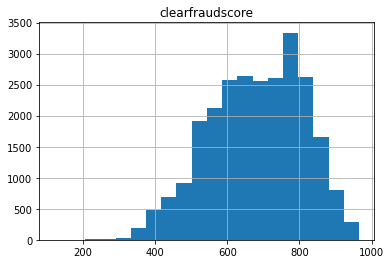

In [24]:
# Lets see the distribution for clearfraudscore
final_manager.data.hist('clearfraudscore', bins=20)

array([[<AxesSubplot:title={'center':'clearfraudscore'}>]], dtype=object)

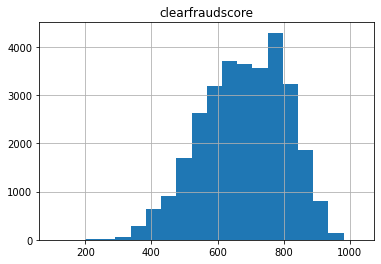

In [25]:
# Impute with akima interpolation
final_manager.interpolate_smooth('clearfraudscore')
final_manager.data.hist('clearfraudscore', bins=20)

In [26]:
# Now lets remove the rest of the records with missing values
final_manager.drop_na_rows()
print("Shape after dropping records with NaN or None:", final_manager.data.shape)
print("None and NaN values per column:")
final_manager.na_per_col()

Shape after dropping records with NaN or None: (30672, 15)
None and NaN values per column:


payFrequency                        0
apr                                 0
nPaidOff                            0
loanStatus                          0
loanAmount                          0
originallyScheduledPaymentAmount    0
state                               0
leadType                            0
leadCost                            0
fpStatus                            0
hasCF                               0
applicationYear                     0
paymentAmount                       0
paidOff                             0
clearfraudscore                     0
dtype: int64

In [27]:
# All required data transformation is done, our final data looks like this
final_manager.data.reset_index(inplace=True) # reset index to allow saving to feather
final_manager.drop_column('index')  # Drop after reset
final_manager.display(5, False) # display last n rows

,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,applicationYear,paymentAmount,paidOff,clearfraudscore
30667,M,180.2,0.0,Returned Item,500.0,794.60,CO,lead,25,Rejected,1,2017,0.00,False,695.000000
30668,B,565.0,3.0,Paid Off Loan,600.0,1670.18,CA,rc_returning,0,Checked,0,2016,895.06,False,669.471505
30669,M,645.0,0.0,Paid Off Loan,375.0,1042.40,AL,lead,25,Checked,1,2017,461.29,False,700.000000
30670,B,449.0,0.0,Paid Off Loan,400.0,664.12,WI,lead,40,Checked,1,2016,664.12,True,806.000000
30671,W,645.0,0.0,Paid Off Loan,300.0,1034.38,CT,lead,6,Checked,1,2016,347.79,False,827.000000


In [28]:
# Final step: Save the data in feather format
filename = 'transformed'
save_path = os.path.join(feather_path, filename)    # save to data-feathers directory
final_manager.feather_df(save_path)

In [29]:
# Check if save is alright
transformed_manager = DataLoader()
transformed_path = os.path.join(feather_path, 'transformed')
transformed_manager.load_feather(transformed_path)

In [30]:
"""
Everything matches! Now this data will be used for EDA and modelling.
"""
print("Shape of transformed data:", transformed_manager.data.shape)
transformed_manager.display(5, False) 

Shape of transformed data: (30672, 15)


,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,applicationYear,paymentAmount,paidOff,clearfraudscore
30667,M,180.2,0.0,Returned Item,500.0,794.60,CO,lead,25,Rejected,1,2017,0.00,False,695.000000
30668,B,565.0,3.0,Paid Off Loan,600.0,1670.18,CA,rc_returning,0,Checked,0,2016,895.06,False,669.471505
30669,M,645.0,0.0,Paid Off Loan,375.0,1042.40,AL,lead,25,Checked,1,2017,461.29,False,700.000000
30670,B,449.0,0.0,Paid Off Loan,400.0,664.12,WI,lead,40,Checked,1,2016,664.12,True,806.000000
30671,W,645.0,0.0,Paid Off Loan,300.0,1034.38,CT,lead,6,Checked,1,2016,347.79,False,827.000000
